# NLP Project 2

## News Article Classification

###  Introduction

In today’s digital world, news articles are constantly being generated and shared across
 different platforms. For news organizations, social media platforms, and aggregators,
 classifying articles into specific categories such as sports, politics, and technology can help
 improve content management and recommendation systems. This project aims to develop a
 machine learning model that can classify news articles into predefined categories, such as
 sports, politics, and technology, based on their content.
 By automating this process, organizations can efficiently categorize large volumes of news
 articles, making it easier for readers to access relevant information based on their interests.

### Problem Statement
 The primary objective of the project is to build a classification model that can automatically
 categorize news articles into different predefined categories. The model is trained using
 a labeled dataset of news articles and output the most likely category (e.g., sports,
 politics, or technology) for any given article.

### Data loading , EDA and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [3]:
# Load the dataset
df = pd.read_csv("data_news.csv")

In [5]:
df.head()

,category,headline,links,short_description,keywords
0,WELLNESS,143 Miles in 35 Days: Lessons Learned,https://www.huffingtonpost.com/entry/running-l...,Resting is part of training. I've confirmed wh...,running-lessons
1,WELLNESS,Talking to Yourself: Crazy or Crazy Helpful?,https://www.huffingtonpost.com/entry/talking-t...,Think of talking to yourself as a tool to coac...,talking-to-yourself-crazy
2,WELLNESS,Crenezumab: Trial Will Gauge Whether Alzheimer...,https://www.huffingtonpost.com/entry/crenezuma...,The clock is ticking for the United States to ...,crenezumab-alzheimers-disease-drug
3,WELLNESS,"Oh, What a Difference She Made",https://www.huffingtonpost.com/entry/meaningfu...,"If you want to be busy, keep trying to be perf...",meaningful-life
4,WELLNESS,Green Superfoods,https://www.huffingtonpost.com/entry/green-sup...,"First, the bad news: Soda bread, corned beef a...",green-superfoods


In [7]:
df.shape

(50000, 5)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  50000 non-null  object
 4   keywords           47332 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


In [11]:
df.isnull().sum()

category                0
headline                0
links                   0
short_description       0
keywords             2668
dtype: int64

In [13]:
''' Encountered 2668 null values out of 50000 in the classification project , its a significant but manageable issue. 
    As it represents only 5.3% of your data.'''

df.dropna(subset = ["keywords"], inplace=True )


In [15]:
df.isnull().sum()

category             0
headline             0
links                0
short_description    0
keywords             0
dtype: int64

In [17]:
df.shape

(47332, 5)

C:\Users\mayan\AppData\Local\Temp\ipykernel_24900\1595630391.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='category',palette = 'pastel')


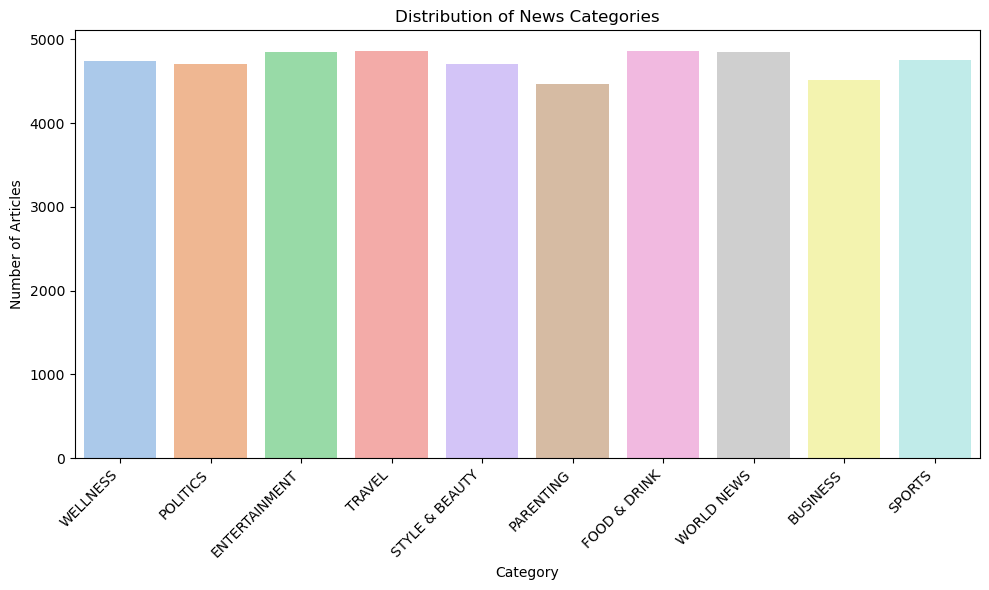

In [19]:
# Visualization of category distribution

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='category',palette = 'pastel')
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Key finding 

* The distribution of articles across categories is relatively uniform with each category having between 4500 to 5000 articles.
* This balanced dataset helps avoid bias during model training and contributes to more fair and accurate classification performance.

In [22]:
#     combining both headline and short description

df["combined_text"] = df["headline"] + " " + df["short_description"]

In [24]:
df["combined_text"][1]

'Talking to Yourself: Crazy or Crazy Helpful? Think of talking to yourself as a tool to coach yourself through a challenge, or to narrate your own experiences to yourself. In any case, treat yourself with respect and you just may find you enjoy your own company.'

In [26]:
#      Preprocessing the data

stop_words = set(stopwords.words('english'))

def processed_text(text):
    text = text.lower()
    text= re.sub( r'[^\w\s]',' ',text)
    tokens = text.split()
    tokens = [ WordNetLemmatizer().lemmatize(word) for word in tokens if word not in stop_words ]
    return ' '.join(tokens)

df["processed_text"] = df["combined_text"].apply(processed_text)

In [27]:
df["processed_text"][1]

'talking crazy crazy helpful think talking tool coach challenge narrate experience case treat respect may find enjoy company'

In [71]:
print("First five rows of combined text and proessed text : \n", df[[ "combined_text", "processed_text"]].head())

First five rows of combined text and proessed text : 
                                        combined_text  \
0  143 Miles in 35 Days: Lessons Learned Resting ...   
1  Talking to Yourself: Crazy or Crazy Helpful? T...   
2  Crenezumab: Trial Will Gauge Whether Alzheimer...   
3  Oh, What a Difference She Made If you want to ...   
4  Green Superfoods First, the bad news: Soda bre...   

                                      processed_text  
0  143 mile 35 day lesson learned resting part tr...  
1  talking crazy crazy helpful think talking tool...  
2  crenezumab trial gauge whether alzheimer drug ...  
3  oh difference made want busy keep trying perfe...  
4  green superfoods first bad news soda bread cor...  


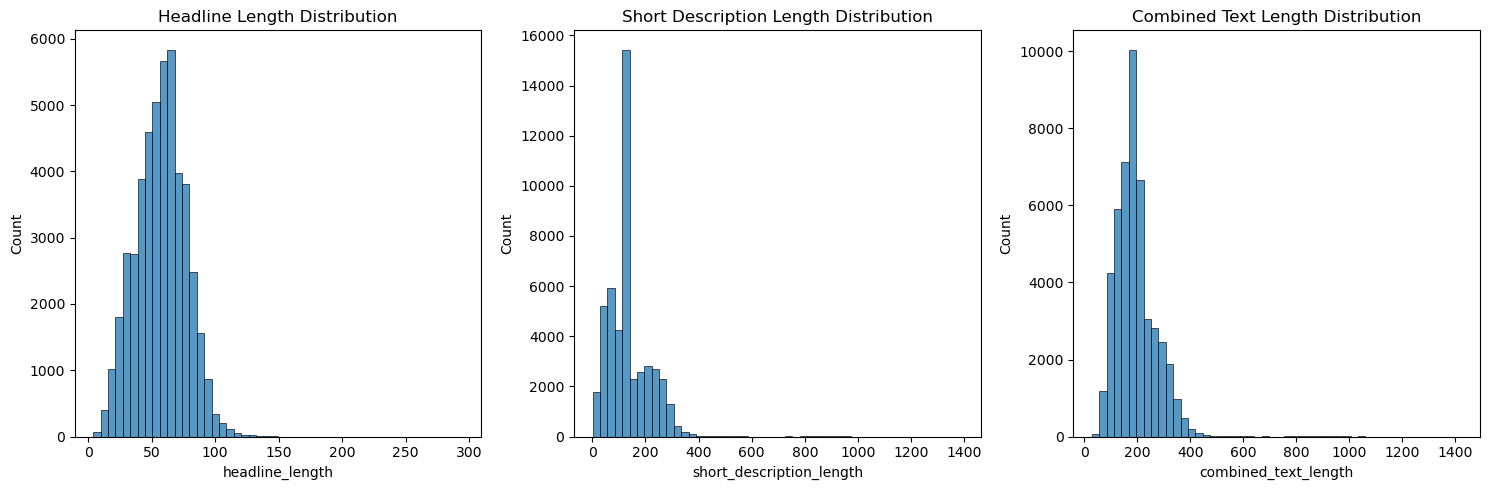

In [85]:
# Analyze text length
df['headline_length'] = df['headline'].apply(len)
df['short_description_length'] = df['short_description'].apply(len)
df['combined_text_length'] = df['combined_text'].apply(len)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['headline_length'], bins=50)
plt.title('Headline Length Distribution')

plt.subplot(1, 3, 2)
sns.histplot(df['short_description_length'], bins=50)
plt.title('Short Description Length Distribution')

plt.subplot(1, 3, 3)
sns.histplot(df['combined_text_length'], bins=50)
plt.title('Combined Text Length Distribution')

plt.tight_layout()
plt.show()

### Key Findings

* Headline length Distribution : The distribution is slightly right-skewed, so most of headlines are between 30 to 70 characters. Also very few headlines exceed 100 chracters.
* Short Description Length Distribution : There are noticeable peaks around 200 charactres  and most of the short discription falls between 150 to 300 characters.
* Commbined text length distribution : The distribution is centered around 150 to 250 characters. This combined input is well suited for text vactorization methods like TF IDF.

  Since there is no significant presence of outliers , i ensure and perform the next tasks.

#### Feature Extraction

In [30]:
#    Feature extraction using Tf-Idf
tfidf_vectorizer = TfidfVectorizer(max_features=10000) 
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_text'])

#   Defining features (X) and target (y)
X = tfidf_matrix
y = df['category']

#   Splitting the data into into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)


Training data shape: (37865, 10000) (37865,)
Testing data shape: (9467, 10000) (9467,)


### Model Develpment and Evaluation

In [41]:
#   Logistic Regression

lr = LogisticRegression( max_iter = 700 , random_state = 42)
lr.fit(X_train, y_train)
lr_y_predict = lr.predict(X_test)

# Evaluation of Logistic Regression
print("\n--- Logistic Regression ---")
print(" \n Accuracy:", accuracy_score(y_test, lr_y_predict))
print(" \n Classification Report:\n", classification_report(y_test, lr_y_predict))
print(" \n Confussion Matrix:\n ", confusion_matrix(y_test, lr_y_predict))



--- Logistic Regression ---
 
 Accuracy: 0.8220133093905144
 
 Classification Report:
                 precision    recall  f1-score   support

      BUSINESS       0.79      0.79      0.79       908
 ENTERTAINMENT       0.79      0.81      0.80       923
  FOOD & DRINK       0.86      0.86      0.86       987
     PARENTING       0.80      0.79      0.80       900
      POLITICS       0.81      0.77      0.79       955
        SPORTS       0.89      0.90      0.90       968
STYLE & BEAUTY       0.89      0.85      0.87       903
        TRAVEL       0.82      0.82      0.82       958
      WELLNESS       0.74      0.81      0.77       969
    WORLD NEWS       0.84      0.82      0.83       996

      accuracy                           0.82      9467
     macro avg       0.82      0.82      0.82      9467
  weighted avg       0.82      0.82      0.82      9467

 
 Confussion Matrix:
  [[714  10  21  18  43  14   5  21  37  25]
 [ 10 752   6  31  17  25  26  24  22  10]
 [ 12  12 849  

In [34]:
#    Naive Bayes 

nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_y_predict = nb.predict(X_test)

# Evaluation of Naive Bayes
print("\n--- Naive Bayes ---")
print("Accuracy:", accuracy_score(y_test, nb_y_predict))
print("Classification Report:\n", classification_report(y_test, nb_y_predict))
print("Confussion Matrix:\n", confusion_matrix(y_test, nb_y_predict))


--- Naive Bayes ---
Accuracy: 0.8073307277912749
Classification Report:
                 precision    recall  f1-score   support

      BUSINESS       0.79      0.71      0.75       908
 ENTERTAINMENT       0.81      0.79      0.80       923
  FOOD & DRINK       0.85      0.87      0.86       987
     PARENTING       0.72      0.78      0.75       900
      POLITICS       0.80      0.76      0.78       955
        SPORTS       0.90      0.87      0.88       968
STYLE & BEAUTY       0.87      0.84      0.85       903
        TRAVEL       0.80      0.83      0.82       958
      WELLNESS       0.71      0.78      0.75       969
    WORLD NEWS       0.83      0.84      0.83       996

      accuracy                           0.81      9467
     macro avg       0.81      0.81      0.81      9467
  weighted avg       0.81      0.81      0.81      9467

Confussion Matrix:
 [[648  13  18  35  54  12   5  28  62  33]
 [  9 729   8  27  16  23  50  20  29  12]
 [  8   4 858  22   2   5  12  44

In [36]:
#   Support Vector Machine

svm = SVC( kernel = 'linear', C=1.0)
svm.fit(X_train, y_train)
svm_y_predict = svm.predict(X_test)

# Evaluation of SVM
print("\n--- Support Vector Machine ---")
print("Accuracy:", accuracy_score(y_test, svm_y_predict))
print("Classification Report:\n", classification_report(y_test, svm_y_predict))
print("Confussion Matrix:\n" , confusion_matrix(y_test, svm_y_predict))


--- Support Vector Machine ---
Accuracy: 0.8243371712263653
Classification Report:
                 precision    recall  f1-score   support

      BUSINESS       0.77      0.80      0.79       908
 ENTERTAINMENT       0.78      0.82      0.80       923
  FOOD & DRINK       0.86      0.88      0.87       987
     PARENTING       0.78      0.79      0.79       900
      POLITICS       0.80      0.77      0.78       955
        SPORTS       0.91      0.91      0.91       968
STYLE & BEAUTY       0.91      0.86      0.88       903
        TRAVEL       0.84      0.81      0.82       958
      WELLNESS       0.75      0.78      0.76       969
    WORLD NEWS       0.85      0.82      0.83       996

      accuracy                           0.82      9467
     macro avg       0.83      0.82      0.82      9467
  weighted avg       0.83      0.82      0.82      9467

Confussion Matrix:
 [[730  15  17  18  45  10   3  15  37  18]
 [ 18 760   6  31  21  21  15  19  22  10]
 [ 11  11 868  16   3 

In [43]:
# Comparing Model's Accuracies 

print(f'Logistic Regression Accuracy: {accuracy_score(y_test, lr_y_predict)*100:.2f}%' )
print(f'Naive Bayes :  {accuracy_score(y_test, nb_y_predict)*100:.2f}%')
print(f'Support Vector Machine: {accuracy_score(y_test, svm_y_predict)*100:.2f}%' )

Logistic Regression Accuracy: 82.20%
Naive Bayes :  80.73%
Support Vector Machine: 82.43%


Key Finding : We can conclude that SVM performs best among all models, logistic regression also performed better but it is slighly less than SVM.

#### Predicting a New news article category 

In [49]:
new_article = input("Enter a news article: ")
new_article_processed =  processed_text(new_article)
new_article_vectorized = tfidf_vectorizer.transform([new_article_processed])
svm_prediction = svm.predict(new_article_vectorized)
print("\n Category  Prediction:", svm_prediction[:])

Enter a news article:  PinkVillas, a new brand of jeans and trouser is new in market.



 Category  Prediction: ['BUSINESS']


### Insights from project

The data quality and preprocessing had a significant impact on model performance .
    
TF-IDF was effective for representing article text, balance word frequency and and uniqueness.

SVM model performed slightly better than others, suggesting it handled complex decision bountries better.

Created an input based prediction tool where user can enter a new article and receive a predicted category. This helped to demostrate the practical application of the model in real time scenarios.

### Video Explanation

https://drive.google.com/file/d/1g7hXb6ikWO060YVxdC9WOtr-7a9P-1fF/view?usp=sharing